# Validation

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent))

from settings.global_settings import GlobalSettings

config = GlobalSettings.get_config(
    config_file = "../config.ini",
    secrets_file = "../secrets.ini"
)
from dataset.video_loader import VideoDataLoader
from dataset.video_dataset import VideoDataset
from model.multimodal_har_model import MultiModalHARModel

Loading config...
Loading secrets...


2025-11-14 09:15:22,758 - INFO - Sentry DSN set to: https://f4f21cc936b3ba9f5dbc1464b7a40ea4@o4504168838070272.ingest.us.sentry.io/4506464560414720
2025-11-14 09:15:22,759 - INFO - Sentry initialized with environment: development


**Parameters**

In [2]:
#MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_2025-11-11 09:45:21.993320.pht"
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_2025-11-14.423179.pht"
MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251114_091037.pht"
VALIDATION_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "validation"
)

## Loading Dataset

In [3]:
validation_video_data_loader = VideoDataLoader(
    path=VALIDATION_DIR,
)
validation_dataset = VideoDataset(
    video_data_loader=validation_video_data_loader,
    normalization_type="across_frames",
)

len(validation_dataset)
for _ in validation_dataset:
    pass


display(len(validation_dataset.labels_map))

2025-11-14 09:15:24,969 - INFO - [VideoDataLoader] Loding action videos for action: a01
2025-11-14 09:15:25,014 - INFO - [VideoDataLoader] Loding action videos for action: a02
2025-11-14 09:15:25,056 - INFO - [VideoDataLoader] Loding action videos for action: a03
2025-11-14 09:15:25,096 - INFO - [VideoDataLoader] Loding action videos for action: a04
2025-11-14 09:15:25,126 - INFO - [VideoDataLoader] Loding action videos for action: a05
2025-11-14 09:15:25,155 - INFO - [VideoDataLoader] Loding action videos for action: a06
2025-11-14 09:15:25,192 - INFO - [VideoDataLoader] Loding action videos for action: a08
2025-11-14 09:15:25,330 - INFO - [VideoDataLoader] Loding action videos for action: a09
2025-11-14 09:15:25,383 - INFO - [VideoDataLoader] Loding action videos for action: a11
2025-11-14 09:15:25,422 - INFO - [VideoDataLoader] Loding action videos for action: a12


10

## Loading Model

In [4]:
har_model, _ = MultiModalHARModel.load(
    checkpoint_path=MODEL_PHT_PATH
)

2025-11-14 09:15:25,933 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251114_091037.pht...
2025-11-14 09:15:26,026 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 128, 'gat_out': 128, 'temporal_hidden': 128, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'max'}
2025-11-14 09:15:26,027 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 128, 'gat_out': 128, 'temporal_hidden': 128, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'max'}
2025-11-14 09:15:26,092 - INFO - ✅ Model loaded and ready for inference


## Quantitative Validation

- Accuracy
- AUC

In [5]:
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from typing import Tuple, List
from tqdm import tqdm

@torch.no_grad()
def evaluate_model(
    model: nn.Module,
    dataset: VideoDataset,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluates a trained model on a VideoDataset.
    Computes accuracy and macro-averaged AUC.
    """
    model.eval()
    y_true_list: List[int] = []
    y_pred_logits_list: List[torch.Tensor] = []

    for video_data in tqdm(dataset, desc="Evaluating"):
        graphs_objects = [g.to(device) for g in video_data.graphs_objects]
        graphs_joints = [g.to(device) for g in video_data.graphs_joints]
        label = video_data.label.to(device)

        # Forward pass
        logits: torch.Tensor = model(graphs_objects, graphs_joints)
        y_pred_logits_list.append(logits.cpu())
        y_true_list.append(label.cpu().item())

    # Concatenate results
    y_true = torch.tensor(y_true_list)
    y_pred_logits = torch.cat(y_pred_logits_list, dim=0)

    # Compute metrics
    accuracy, auc = compute_metrics(y_true, y_pred_logits)
    return accuracy, auc


def compute_metrics(
    y_true: torch.Tensor,
    y_pred_logits: torch.Tensor
) -> Tuple[float, float]:
    """
    Compute accuracy and macro-AUC.
    Args:
        y_true: Tensor of shape (N,) with integer labels.
        y_pred_logits: Tensor of shape (N, C) with raw model outputs (before softmax).
    Returns:
        (accuracy, macro_auc)
    """
    y_true_np = y_true.numpy()
    y_pred_np = torch.softmax(y_pred_logits, dim=1).numpy()

    preds = y_pred_np.argmax(axis=1)
    accuracy: float = (preds == y_true_np).mean()

    try:
        auc: float = roc_auc_score(y_true_np, y_pred_np, multi_class='ovr', average='macro')
    except ValueError:
        auc = float('nan')

    return accuracy, auc


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
har_model.to(device)

accuracy, auc = evaluate_model(har_model, validation_dataset, device)
print(f"Validation Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")


Evaluating: 100%|██████████| 152/152 [00:02<00:00, 50.77it/s]

Validation Accuracy: 0.7763, AUC: 0.9709


## Qualitative Validation

- Graphic Analysis - Plotting with t-SNE

In [11]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def extract_embeddings(
    model: MultiModalHARModel,
    dataset: VideoDataset,
    device="cpu"
):
    model.eval()

    embeddings = []
    labels = []

    for sample in tqdm(dataset, desc="Extracting embeddings"):
        graphs_objects = sample.graphs_objects
        graphs_joints = sample.graphs_joints
        label = sample.label

        # Move to device
        graphs_objects = [g.to(device) for g in graphs_objects]
        graphs_joints = [g.to(device) for g in graphs_joints]

        emb = model.forward_features(graphs_objects, graphs_joints)
        embeddings.append(emb.cpu().detach().numpy())
        labels.append(label)

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)

    return embeddings, labels

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_tsne(
    embeddings: np.ndarray,
    labels: np.ndarray,
    num_classes: int,
    perplexity: int = 30,
    random_state: int = 42,
    n_components: int = 2
):
    """
    Plots t-SNE visualization of embeddings in 2D or 3D.
    """
    print(f"Running t-SNE with {n_components} dimensions...")

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        random_state=random_state,
        init="pca"
    )
    reduced = tsne.fit_transform(embeddings)

    if n_components == 2:
        # ---- 2D Visualization ----
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            reduced[:, 0],
            reduced[:, 1],
            c=labels,
            cmap="tab10",
            s=40,
            alpha=0.8
        )
        plt.colorbar(scatter, ticks=range(num_classes))
        plt.title("2D t-SNE visualization")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.show()

    elif n_components == 3:
        # ---- 3D Visualization ----
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            reduced[:, 0],
            reduced[:, 1],
            reduced[:, 2],
            c=labels,
            cmap="tab10",
            s=40,
            alpha=0.85
        )

        fig.colorbar(scatter, ticks=range(num_classes))
        ax.set_title("3D t-SNE visualization")
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        ax.set_zlabel("t-SNE 3")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("n_components must be 2 or 3")


Extracting embeddings: 100%|██████████| 152/152 [00:02<00:00, 51.93it/s]


Running t-SNE with 3 dimensions...


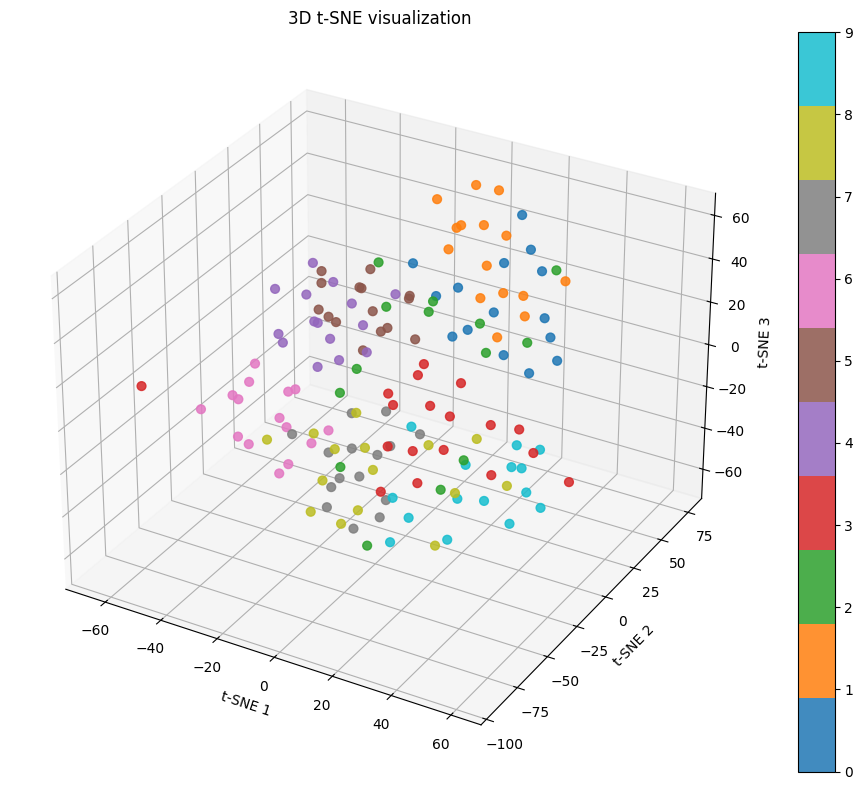

In [13]:

embeddings, labels = extract_embeddings(har_model, validation_dataset, device)
visualize_tsne(embeddings, labels, num_classes=10, n_components=3)

Printing tSNE values

In [14]:
perplexity = 30
random_state = 42

tsne = TSNE(
    n_components=3,
    perplexity=perplexity,
    random_state=random_state,
    init="pca"
)
reduced = tsne.fit_transform(embeddings)


In [16]:
import numpy as np
from pathlib import Path

# Create output directory
output_dir = Path("validation_results")
output_dir.mkdir(exist_ok=True)

# Write to text file
output_file = output_dir / f"tsne_results_perplexity_{perplexity}_seed_{random_state}.txt"

with open(output_file, 'w') as f:
    f.write(f"t-SNE Results (perplexity={perplexity}, random_state={random_state})\n")
    f.write("=" * 50 + "\n")
    f.write("Point_X,Point_Y,Point_Z,Label\n")
    
    for point, label in zip(reduced, labels):
        f.write(f"{point[0]:.6f},{point[1]:.6f},{point[2]:.6f},{label}\n")

print(f"✅ Results saved to {output_file}")

✅ Results saved to validation_results/tsne_results_perplexity_30_seed_42.txt
